In [1]:
! pip install nnAudio==0.0.9

# Helper function

In [2]:
def get_dummy_dataset():
    fs = 44100
    interval = 0.2
    t = np.linspace(0, interval, int(fs*interval))
    fmin = 200

    X = np.zeros(((fs//2-fmin)//2*10, int(fs*interval)), np.float32)
    Y = np.zeros((fs//2-fmin)//2*10, np.float32)
    counter=0
    for k in tqdm(range(fmin,fs//2, 2)): # Creating signals with different frequencies
         for phi in np.arange(0,1,0.1):
            X[counter]=np.sin(2*np.pi*(k*t+phi))
            Y[counter]=k/interval
            counter+=1
    return X, Y

In [3]:
from nnAudio import Spectrogram
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.model_selection import train_test_split
import torch
import torchvision

import os
os.environ['CUDA_VISIBLE_DEVICES']='0'

if torch.cuda.is_available():
    device = "cuda:0"

In [4]:
X, Y = get_dummy_dataset() # This dummy dataset generate a pure sine wave as X and frequency as the label Y
X[0].shape

100%|██████████| 10925/10925 [00:26<00:00, 408.86it/s]


(8820,)

In [5]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y.reshape(-1,1), test_size=0.2, random_state=101)

In [6]:
trainset = torch.utils.data.TensorDataset(torch.tensor(X_train, device='cpu'), torch.tensor(Y_train, device='cpu'))
testset = torch.utils.data.TensorDataset(torch.tensor(X_test, device='cpu'), torch.tensor(Y_test, device='cpu'))

In [7]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=512)
testloader = torch.utils.data.DataLoader(testset, batch_size=512)

In [11]:
# Creating h
class Model(torch.nn.Module):
    def __init__(self):
        super(Model,self).__init__()
        self.stft = Spectrogram.STFT(n_fft=64, trainable=True, device=device)
        self.CNN_layer1 = torch.nn.Conv2d(1,1, kernel_size=(4,4)).cuda(device)
        self.CNN_layer2 = torch.nn.Conv2d(1,1, kernel_size=(4,4)).cuda(device)
        
        self.regressor = torch.nn.Linear(27*12,1).cuda(device)

    def forward(self, x):
        x = self.stft(x)
        x = self.CNN_layer1(x.unsqueeze(1))
        x = self.CNN_layer2(x)
#         print(x.shape)
        x = x.view(x.data.size()[0], 27*12)
        x = self.regressor(torch.relu(x))
        return torch.sigmoid(x)

In [ ]:
from torchsummary import summary
model = Model()
summary(model, (1,8820))

In [1]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_function = torch.nn.MSELoss() 

NameError: ignored

# Visualizing Original Weights

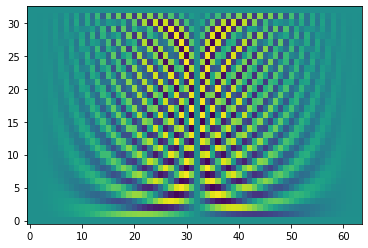

In [18]:
original_basis_real = model.stft.wcos.cpu().detach().numpy().squeeze(1)
original_basis_imag = model.stft.wsin.cpu().detach().numpy().squeeze(1)
plt.imshow(model.stft.wsin.cpu().detach().numpy().squeeze(1), aspect='auto', origin='lower')

# Training Model

In [ ]:
loss_train = []
loss_test = []

print("epoch\ttrain loss\ttest loss")
for e in range(40):
    loss_train_e = 0.0
    loss_test_e = 0.0

    for i, (x, y) in enumerate(trainloader):
        x = x.cuda()
        y = y.cuda()/110240 # Normalizing to labels to [0,1]
        optimizer.zero_grad()
        y_pred = model(x)
        loss = loss_function(y_pred, y)
        loss.backward() # Calculating gradient
        optimizer.step() # Updating paramenters by gradient
        loss_train_e += loss.item()
        print(f"training {i}/{len(trainloader)} batches, loss = {loss.item():.6f}", end = '\r')
    loss_train.append(loss_train_e/len(trainloader))
   
    with torch.no_grad():
        for x, y in testloader:
            x = x.cuda()
            y = y.cuda()/110240
            y_pred = model(x)
            loss = loss_function(y_pred, y)
            loss_test_e +=loss.item()
        loss_test.append(loss_test_e/len(testloader))
        print(' '*100, end='\r')
        print(f"{e}\t{loss_train[-1]:.6f}\t{loss_test[-1]:.6f}")

# Visualizing Trained Weights

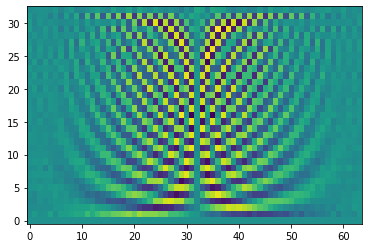

In [ ]:
trained_basis_real = model.stft.wsin.cpu().detach().numpy().squeeze(1)
trained_basis_imag = model.stft.wcos.cpu().detach().numpy().squeeze(1)
plt.imshow(model.stft.wsin.cpu().detach().numpy().squeeze(1), aspect='auto', origin='lower')

# Have a closer look on the STFT basis

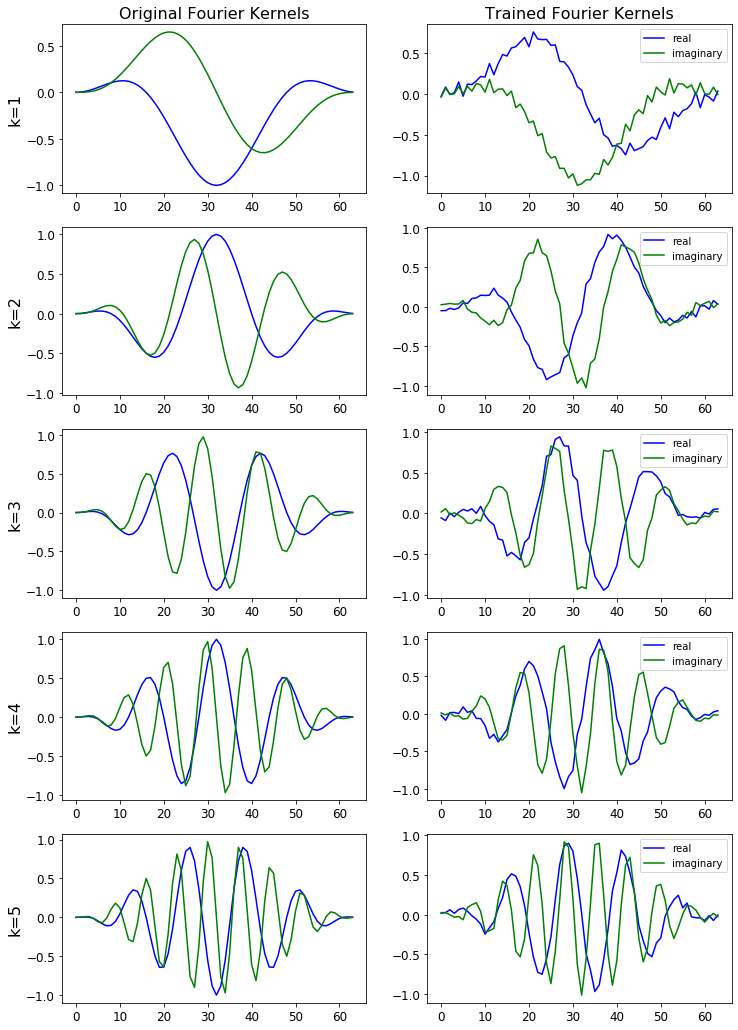

In [ ]:
fig, ax = plt.subplots(5,2, figsize=(12,18))
cols = ['Original Fourier Kernels', 'Trained Fourier Kernels']
rows = np.arange(1,6)
for ax_idx, col in zip(ax[0], cols):
    ax_idx.set_title(col, size=16)
for ax_idx, row in zip(ax[:,0], rows):
    ax_idx.set_ylabel(f'k={row}', size=16)    
    

for i in range(5):
    ax[i,0].plot(original_basis_real[i+1], 'b')
    ax[i,1].plot(trained_basis_real[i+1], 'b')
    ax[i,0].tick_params(labelsize=12)
    ax[i,1].tick_params(labelsize=12)
    
for i in range(5):
    ax[i,0].plot(original_basis_imag[i*2+1], 'g')
    ax[i,1].plot(trained_basis_imag[i*2+1], 'g')
    ax[i,0].tick_params(labelsize=12)
    ax[i,1].tick_params(labelsize=12)
    ax[i,1].legend(['real','imaginary'])


# Trained STFT

Text(0.5, 1.0, 'Trained STFT')

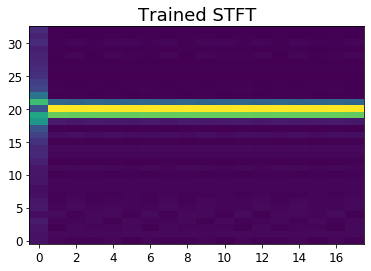

In [ ]:
plt.imshow(model.stft(x)[0].cpu().detach().numpy(), aspect='auto', origin='lower')
plt.tick_params(labelsize=12)
plt.title('Trained STFT', size=18)

# Original STFT

STFT kernels created, time used = 0.0023 seconds


Text(0.5, 1.0, 'Original STFT')

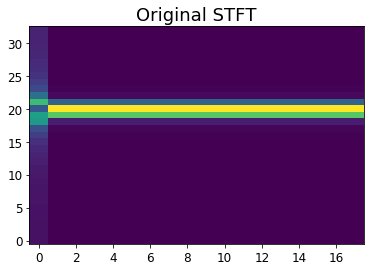

In [ ]:
ori_stft = Spectrogram.STFT(n_fft=64, trainable=True)
plt.imshow(ori_stft(x)[0].cpu().detach().numpy(), aspect='auto', origin='lower')
plt.tick_params(labelsize=12)
plt.title('Original STFT', size=18)